In [12]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
#If you want to consider inf and -inf to be “NA” in computations, you can set
pd.options.mode.use_inf_as_na = True
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def nulls(df):
    nulls = pd.DataFrame(df.isnull().sum().sort_values(), columns=['nulls'])
    nulls['porcentaje'] = round(100*nulls['nulls'] / len(df), 2)
    nulls.sort_values('porcentaje')
    return nulls

pd.options.display.max_colwidth = 100
pd.options.display.max_rows = 999

## La idea es unir todas las bases de datos que voy a utilizar

### Personas que viven en Avellaneda, geolocalizadas con su correspondiente radiocensal



In [13]:
dnixradio=pd.read_csv('Datos/universoavellclink2.csv', sep=';')
dnixradio.sort_values(by=['domicilio','seccionid','circuitoid','mesa', 'link'], inplace=True)
dnixradio.replace({'link': 0}, {'link': np.nan}, inplace=True)
dnixradio.fillna(method='pad', inplace=True)
dnixradio1 =dnixradio[['dni','genero', 'años', 'link']].copy()
dnixradio2=pd.read_csv('Datos/radioxdni.csv', sep=';')
dnixradio2.sort_values(by=['DIRECCION', 'link'], inplace=True)
dnixradio2.replace({'link': 0}, {'link': np.nan}, inplace=True)
dnixradio2.fillna(method='bfill', inplace=True)
dnixradio2 =dnixradio2[['DNI','GENERO', 'Edad2', 'link']].copy()
dnixradio2.rename(columns={'DNI': 'dni', 'Edad2': 'años', 'GENERO': 'genero'}, inplace=True)

In [14]:
universoavellcradio=dnixradio1.append(dnixradio2, ignore_index=True)

In [15]:
universoavellcradio.drop_duplicates('dni',keep='first', inplace=True)
universoavellcradio= universoavellcradio.astype({'link': int})

#### Observaciones por sexo

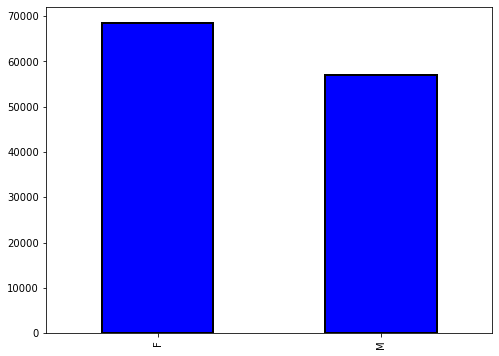

In [16]:
universoavellcradio['genero'].value_counts().plot.bar(color = 'blue', figsize = (8, 6), edgecolor = 'k', linewidth = 2);

#### Observaciones por Edad
Vemos que hay muchas observaciones con edad 0, deberán ser corregidas

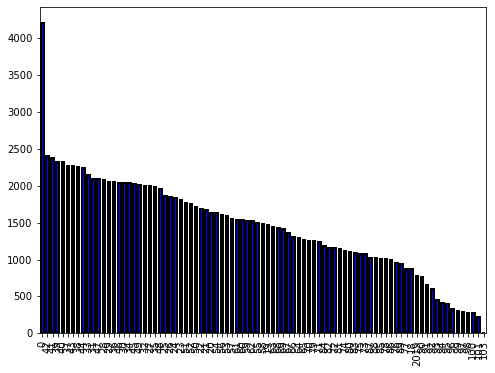

In [17]:
universoavellcradio['años'].value_counts().plot.bar(color = 'blue', figsize = (8, 6), edgecolor = 'k', linewidth = 2);#HAY QUE COMPLETAR LOS 2019

In [18]:
universoavellcradio.sort_values(by='dni', inplace=True)

In [19]:
#completamos los años que estan incompletos con los datos del siguiente
universoavellcradio.replace({'años': 2019}, {'años': np.nan}, inplace=True)
universoavellcradio.replace({'años': 0}, {'años': np.nan}, inplace=True)
universoavellcradio.fillna(method='pad', inplace=True)

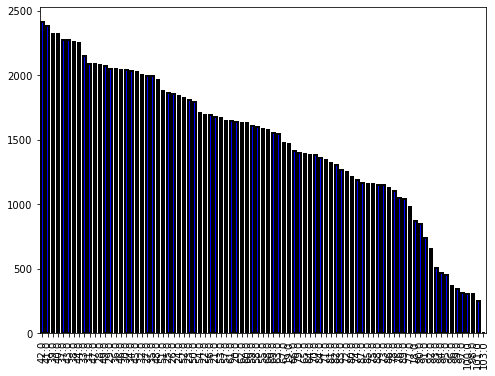

In [20]:
universoavellcradio['años'].value_counts().plot.bar(color = 'blue', figsize = (8, 6), edgecolor = 'k', linewidth = 2);#HAY QUE COMPLETAR LOS 2019

In [21]:
universoavellcradio.head()

,dni,genero,años,link
72636,2462,F,91.0,60351605
173997,3435,F,101.0,60352712
76837,5495,F,89.0,60351006
171435,6251,F,90.0,60351012
139604,6474,F,98.0,60350109


In [22]:
universoavellcradio.to_csv('Datos/universoavellcradio.csv')

### Información de situación financiera de los habitantes de la ciudad de Avellaneda

In [23]:
deudores=pd.read_csv('Datos/Datos finales_Deudores.txt', sep=',')


C:\Users\FLORENCIA\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [24]:
deudores.shape

(406664, 7)

#### Analizamos el porcentaje de  personas que se encuentran informadas en el BCRA
Más del 60% de los ciudadanos se encuentran informados en la central de deudores.

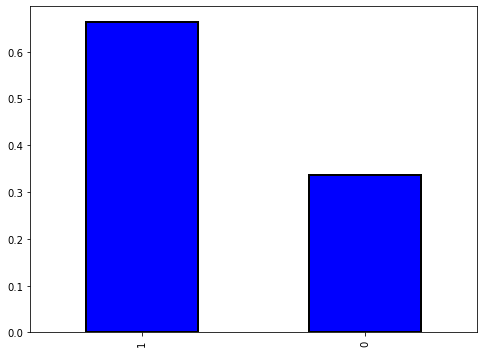

In [25]:
deudores['Tienedeuda'].value_counts(normalize=True).plot.bar(color = 'blue', figsize = (8, 6), edgecolor = 'k', linewidth = 2);

#### Agrupamos por situación informada
Aproximadamente el 80% de los informados se encuentra en situación normal.

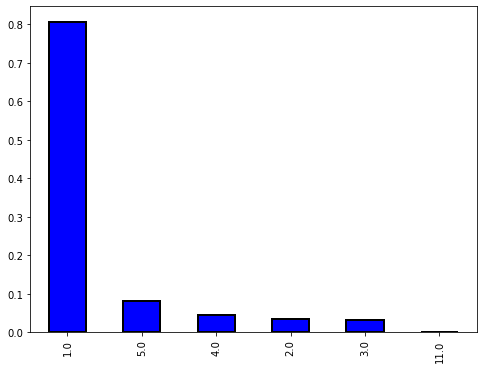

In [26]:
deudores['situacion'].value_counts(normalize=True).plot.bar(color = 'blue', figsize = (8, 6), edgecolor = 'k', linewidth = 2);

#### Porcentaje de clientes informados por tipo de entidad


<AxesSubplot:>

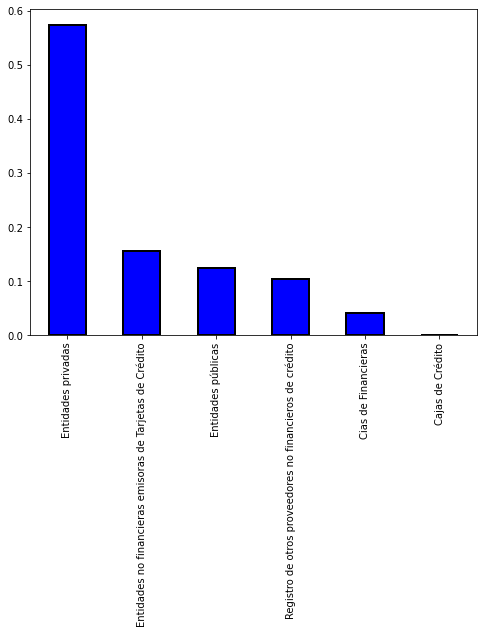

In [27]:
deudores['grupo'].value_counts(normalize=True).plot.bar(color = 'blue', figsize = (8, 6), edgecolor = 'k', linewidth = 2)

#### Analizamos por tipo de entidad, la situación informada de sus clientes
Las entidades públicas y privadas tienen mayor porcentaje de clientes en situación normal.
Mientras que los proveedores no financieros de crédito, tienen más del 50% de sus clientes es situación de mora.

<AxesSubplot:xlabel='grupo,situacion'>

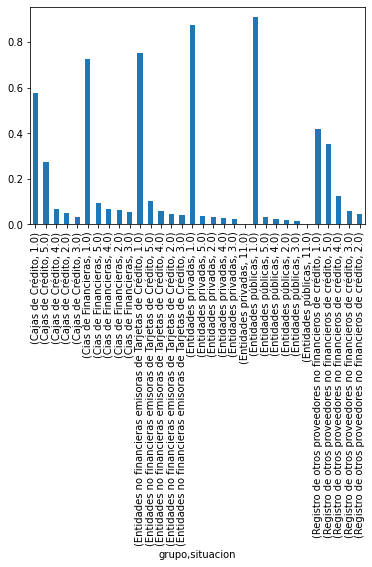

In [28]:
deudores['situacion'].groupby(deudores['grupo']).value_counts(normalize=True).plot.bar()


In [29]:
deudores.rename(columns={'deuda1': 'saldodeuda'}, inplace=True)

Como solo vamos a trabajar con aquellos individuos que se encuentran informados, eliminamos aquellos que no tienen deuda

In [30]:
deudores.dropna(subset=['situacion'], inplace=True)


In [31]:
deudores['Tienedeuda'].value_counts(normalize=True)

1    1.0
Name: Tienedeuda, dtype: float64

In [32]:
deudores.shape

(270028, 7)

In [33]:
deudores['situacion'].value_counts()

1.0     217911
5.0      22275
4.0      11999
2.0       9431
3.0       8396
11.0        16
Name: situacion, dtype: int64

Nos quedan 270 mil registros, los cuales consisten en la deuda informada por dni, por entidad. Es decir, un dni puede tener más de una deuda informada.

Al ser un problema de clasificación binaria, decidimos crear una nueva columna 'target' donde 1 son aquellos informados en situación normal, y 0 aquellos en situación 2 en adelante.

In [34]:
target=pd.read_csv('Datos/target.csv', sep=',')


In [35]:
deudores['target']=deudores['situacion']
#los deudores con situacion mayor a 2 son los q no pagan 0
deudores['target']=deudores['target'].apply(lambda x:0 if x>=2 else 1)

In [36]:
target = deudores.groupby('dni', as_index=False)['target'].max()# como hay más de una deuda por dni, se toma la max. situación informada.
#dejo de cada uno el maximo, analizar porque hay casos q tiene situacion 1 y 5. Es decir pagan uno y otra no

In [37]:
#Realizo la unión de la variable target con los ciudadanos de Avellaneda. 
universoavellcradio=universoavellcradio.merge(target, on='dni', how='left')

In [38]:
universoavellcradio= universoavellcradio.astype({'link': int})

In [39]:
universoavellcradio.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125529 entries, 0 to 125528
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   dni     125529 non-null  int64  
 1   genero  125529 non-null  object 
 2   años    125529 non-null  float64
 3   link    125529 non-null  int32  
 4   target  69636 non-null   float64
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 5.3+ MB


Del total de las personas de Avellaneda que poseen deuda con el sistema financiero, más del 80% se encuentra en situación normal

<AxesSubplot:>

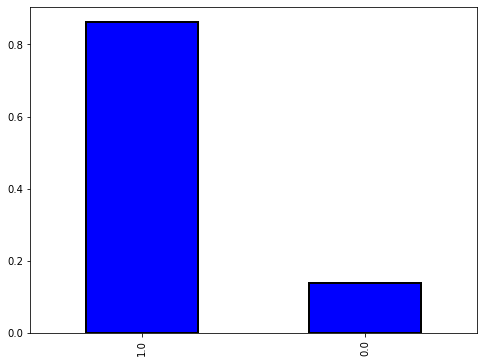

In [40]:
universoavellcradio['target'].value_counts(normalize=True).plot.bar(color = 'blue', figsize = (8, 6), edgecolor = 'k', linewidth = 2)

### Indicadores Sociodemográficos

In [41]:
indicadores=pd.read_csv('Datos/avellindicadores.csv', sep=',', decimal='.')
#hay columnas que no utilizo
indicadores.drop(['toponimo_i', 'varon', 'mujer', 'totalpobl', 'hogares',
       'viviendasp', 'viv_part_h', 'superficie', 'densidad_p'],axis=1, inplace=True)

Son 387 radios censales con 17 indicadores, que se detallan a continuación

In [42]:
indicadores.info()
#indicadores= indicadores.astype({'superficie': int})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387 entries, 0 to 386
Data columns (total 16 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   link                                      387 non-null    int64  
 1   personasxvivienda                         387 non-null    float64
 2   Area_RC                                   387 non-null    float64
 3   Pje_Total_BP_en_RC                        387 non-null    float64
 4   Porcentaje_de_hogares_con_conexion_a_red  387 non-null    float64
 5   %conaccesoredgas                          387 non-null    float64
 6   %dehogarescnib                            387 non-null    float64
 7   %conaccesoredeagua                        387 non-null    float64
 8   connivelsec                               387 non-null    float64
 9   cestudiosuper                             387 non-null    float64
 10  cal1                                  

El valor de cada indicador corresponde al % de hogares que se encuentran cubiertos por ese indicadores dentro del radio censal. A continuación se muestran las principales características descriptivas de cada uno.

In [43]:
indicadores.describe()

,link,personasxvivienda,Area_RC,Pje_Total_BP_en_RC,Porcentaje_de_hogares_con_conexion_a_red,%conaccesoredgas,%dehogarescnib,%conaccesoredeagua,connivelsec,cestudiosuper,cal1,malacmateriales,palto,pmedioalto,pbajo,pmuybajo
count,3.870000e+02,387.000000,3.870000e+02,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000,387.000000
mean,6.035173e+07,3.323040,1.474920e+05,3.147829,69.615323,79.364289,5.569302,99.227674,51.600310,64.704970,91.483618,8.516382,43.623566,7.533411,37.395659,11.447545
std,9.743372e+02,0.789150,4.690173e+05,12.770985,33.578566,24.686898,6.905284,2.124439,6.089158,4.688391,12.066599,12.066599,19.523441,3.137332,12.553022,11.516930
min,6.035010e+07,1.992424,7.610447e+03,0.000000,2.620000,0.000000,0.000000,71.650000,32.720000,47.747748,26.070000,0.000000,1.670000,0.410000,7.210000,0.000000
25%,6.035090e+07,2.889650,6.535793e+04,0.000000,47.585000,76.940000,1.230000,99.240000,47.965000,61.726833,90.845000,2.230000,29.440000,5.520000,28.480000,3.865000
50%,6.035170e+07,3.147147,8.930241e+04,0.000000,84.670000,89.560000,2.850000,99.650000,52.410000,65.207877,95.450000,4.550000,45.850000,7.520000,38.490000,7.270000
75%,6.035260e+07,3.595209,1.168468e+05,0.000000,97.130000,94.830000,7.015000,100.000000,55.915000,68.132072,97.770000,9.155000,58.050000,9.765000,46.910000,13.695000
max,6.035351e+07,10.444444,5.770070e+06,99.990000,100.000000,100.000000,35.160000,100.000000,68.880000,78.590078,100.000000,73.930000,84.380000,15.030000,71.710000,55.240000


Junto el archivo de los indicadores al archivo de dni por radio

In [44]:
dnixradiocindi=universoavellcradio.merge(indicadores, on='link', how='left')

In [45]:
dnixradiocindi.dropna(inplace=True)

In [46]:
dnixradiocindi.to_csv('Datos/universocontarget.csv')

In [61]:
dnixradiocindi.head()

,dni,años,link,target,personasxvivienda,Area_RC,Pje_Total_BP_en_RC,Porcentaje_de_hogares_con_conexion_a_red,%conaccesoredgas,%dehogarescnib,%conaccesoredeagua,connivelsec,cestudiosuper,cal1,malacmateriales,palto,pmedioalto,pbajo,pmuybajo,genero_F,genero_M,genero_nan,antiguedadmeses
0,8863,95.0,60351808,1.0,2.932735,57051.814647,0.00,50.22,95.20,0.00,100.00,50.22,65.584416,99.10,0.90,54.90,7.84,33.82,3.43,1,0,0,148.0
1,9394,85.0,60351003,1.0,3.214035,154392.387052,0.70,94.83,63.64,20.54,99.66,51.07,61.964286,86.67,13.33,37.16,8.81,39.85,14.18,1,0,0,88.0
2,9411,84.0,60351105,1.0,3.287081,38329.211557,0.00,71.19,96.16,2.93,99.27,42.73,65.573770,97.61,2.39,68.22,7.56,20.74,3.49,1,0,0,0.0
3,48754,93.0,60350702,1.0,3.608150,134974.633728,0.47,90.70,60.23,10.09,99.71,56.46,64.190193,88.09,11.91,31.56,6.31,50.83,11.30,1,0,0,118.0
4,51230,89.0,60351108,1.0,2.621469,112628.012503,0.00,100.00,90.41,11.23,99.45,39.88,68.126888,97.46,2.54,70.68,7.40,18.08,3.84,1,0,0,85.0


Observamos que no todos los radios del archivo de los dni geolocalizados fueron correctamente geolocalizados, dado que cayeron en otros radios que no son los de Avellaneda.

In [47]:
dnixradiocindi, dnixradiocindi_cat= one_hot_encoder(dnixradiocindi)

In [48]:
#veo como me quedan las clases representadas
dnixradiocindi['target'].value_counts()

1.0    60014
0.0     9622
Name: target, dtype: int64

### Antiguedad de aquellas personas de Avellaneda que se encuentran en Situación Normal

In [49]:
sit1=pd.read_csv('Datos/sit1.txt', sep=',', infer_datetime_format=True, usecols=['dni', 'antiguedadmeses'])

In [50]:
sit1.drop_duplicates('dni',keep='first', inplace=True)

In [51]:
sit1.shape

(106149, 2)

In [52]:
print('Promedio de meses en situación normal:{}'.format(sit1['antiguedadmeses'].mean()))

Promedio de meses en situación normal:87.28682323903193


In [53]:
print('Promedio de años en situación normal:{}'.format(sit1['antiguedadmeses'].mean()/12))

Promedio de años en situación normal:7.273901936585994


Agregamos la información 

In [54]:
dnixradiocindi=dnixradiocindi.merge(sit1, on='dni', how='left')

Completamos con cero aquellos casos en que no se encuentra informado en situación normal

In [55]:
values = {'antiguedadmeses': 0}
dnixradiocindi.fillna(value=values, inplace=True)

In [56]:
#guardo el archivo para usar en otra notebook
dnixradiocindi.to_csv('Datos/dnixradiocindi.csv')


### Historial crediticio de los últimos 24 meses 
Realizo las agregaciones por dni

In [57]:
historial_total=pd.read_csv('Datos/historialtotalfila.csv')


In [64]:
historial_total.head()

,dni,monto_mean,monto_max,monto_sum,monto_min,monto_std,monto_last,monto_first,codent_nunique,sit_mean,sit_max,sit_min,sit_last,sit_first,pct_mean,pct_max,pct_min,pct_std,pct_var,pct_last
0,6251,46.333333,123,1112,0,45.239139,0,123,1,0.625000,1,0,0,1,-10.929431,1.818182,-100.0,21.231218,450.764617,0.0
1,8863,4.625000,10,111,0,4.547455,10,6,1,0.541667,1,0,1,1,NaN,NaN,-100.0,0.000000,0.000000,NaN
2,9394,273.125000,297,6555,240,16.493246,240,297,1,1.000000,1,1,1,1,-0.872599,0.694444,-4.0,1.522846,2.319058,-4.0
3,9411,10.000000,30,240,0,9.131884,10,11,1,0.625000,1,0,1,1,NaN,NaN,-100.0,0.000000,0.000000,0.0
4,9911,2.625000,21,63,0,7.094471,0,0,1,0.125000,1,0,0,0,NaN,NaN,-100.0,0.000000,0.000000,0.0


In [58]:
#realizo la unión con el dataset original
dnixradiocindixfila=dnixradiocindi.merge(historial_total, on='dni', how='left')
pd.options.display.max_columns = 1000
dnixradiocindixfila.drop(['link'],axis=1, inplace=True)
dnixradiocindixfila.set_index('dni', inplace=True)
dnixradiocindixfila, dnixradiocindixfila_cat= one_hot_encoder(dnixradiocindixfila)

In [59]:
dnixradiocindixfila.to_csv("Datos/dnixradiocindivxfila.csv")


In [60]:
dnixradiocindixfila.shape

(69636, 40)

In [63]:
dnixradiocindixfila.tail()

,años,target,personasxvivienda,Area_RC,Pje_Total_BP_en_RC,Porcentaje_de_hogares_con_conexion_a_red,%conaccesoredgas,%dehogarescnib,%conaccesoredeagua,connivelsec,cestudiosuper,cal1,malacmateriales,palto,pmedioalto,pbajo,pmuybajo,genero_F,genero_M,genero_nan,antiguedadmeses,monto_mean,monto_max,monto_sum,monto_min,monto_std,monto_last,monto_first,codent_nunique,sit_mean,sit_max,sit_min,sit_last,sit_first,pct_mean,pct_max,pct_min,pct_std,pct_var,pct_last
dni,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48683526,25.0,1.0,3.287081,38329.211557,0.0,71.19,96.16,2.93,99.27,42.73,65.573770,97.61,2.39,68.22,7.56,20.74,3.49,1,0,0,41.0,51.979167,180,4990,0,45.917083,130,120,4,0.739583,1,0,1,1,NaN,NaN,-100.000000,0.0,0.0,160.0
49591428,22.0,1.0,3.287081,38329.211557,0.0,71.19,96.16,2.93,99.27,42.73,65.573770,97.61,2.39,68.22,7.56,20.74,3.49,0,1,0,7.0,159.583333,380,3830,0,152.500297,210,0,1,0.750000,2,0,1,0,NaN,NaN,-57.142857,0.0,0.0,-16.0
49591429,20.0,1.0,3.287081,38329.211557,0.0,71.19,96.16,2.93,99.27,42.73,65.573770,97.61,2.39,68.22,7.56,20.74,3.49,1,0,0,9.0,8.333333,60,200,0,17.856108,0,0,1,0.208333,1,0,0,0,NaN,NaN,-100.000000,0.0,0.0,0.0
50068311,21.0,1.0,3.287081,38329.211557,0.0,71.19,96.16,2.93,99.27,42.73,65.573770,97.61,2.39,68.22,7.56,20.74,3.49,1,0,0,3.0,3.333333,80,80,0,16.329932,80,0,1,0.041667,1,0,1,0,NaN,NaN,0.000000,0.0,0.0,NaN
50325010,21.0,0.0,3.504630,95432.030378,0.0,77.31,58.58,8.37,98.74,57.58,64.285714,91.20,8.80,28.95,6.32,54.21,10.53,0,1,0,0.0,9.583333,60,230,0,21.964233,60,0,1,0.291667,3,0,3,0,NaN,NaN,0.000000,0.0,0.0,0.0
